<a href="https://colab.research.google.com/github/Eddy-dashner/linearDeepLearning/blob/gradientDescent/Copy_of_W2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AISaturdaysKigali/cohort2-intro-to-dl/blob/master/tutorials/W2_LinearDeepLearning/W2_Tutorial1.ipynb)

# Tutorial 1: Gradient Descent and AutoGrad

**Week 2: Linear Deep Learning**

---
# Tutorial Objectives

Week 2 Tutorial 1 will continue on buiding PyTorch skillset and motivate its core functionality: Autograd. In this notebook, we will cover the key concepts and ideas of:

* Gradient descent
* PyTorch Autograd
* PyTorch `nn` module

---
# Setup

This a GPU-Free tutorial!


In [ ]:
# Imports
import torch
import numpy as np
from torch import nn
from math import pi
import matplotlib.pyplot as plt

In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/AISaturdaysKigali/content-creation/master/ai6kigali.mplstyle")

In [ ]:
# @title Plotting functions

from mpl_toolkits.axes_grid1 import make_axes_locatable

def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MSE")

  plt.show()


def ex1_plot(fun_z, fun_dz):
  """
  Plots the function and gradient vectors

  Args:
    fun_z: f.__name__
      Function implementing sine function
    fun_dz: f.__name__
      Function implementing sine function as gradient vector

  Returns:
    Nothing
  """
  x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)
  xx, yy = np.meshgrid(x, y, sparse=True)
  zz = fun_z(xx, yy)
  xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
  xxg, yyg = np.meshgrid(xg, yg, sparse=True)
  zxg, zyg = fun_dz(xxg, yyg)

  plt.figure(figsize=(8, 7))
  plt.title("Gradient vectors point towards steepest ascent")
  contplt = plt.contourf(x, y, zz, levels=20)
  plt.quiver(xxg, yyg, zxg, zyg, scale=50, color='r', )
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(contplt, cax=cax)
  cbar.set_label('$z = h(x, y)$')

  plt.show()

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


---
# Section 1: Gradient Descent Algorithm

*Time estimate: ~30-45 mins*

Since the goal of most learning algorithms is **minimizing the risk (also known as the cost or loss) function**, optimization is often the core of most machine learning techniques! The gradient descent algorithm, along with its variations such as stochastic gradient descent, is one of the most powerful and popular optimization methods used for deep learning. Today we will introduce the basics, but you will learn much more about Optimization in the coming days (Week 4).

## Section 1.1: Gradients & Steepest Ascent

### Gradient Descent

Before introducing the gradient descent algorithm, let's review a very important property of gradients. The gradient of a function always points in the direction of the steepest ascent. The following exercise will help clarify this.

### Analytical Exercise 1.1: Gradient vector (Optional)

Given the following function:

\begin{equation}
z = h(x, y) = \sin(x^2 + y^2)
\end{equation}

find the gradient vector:

\begin{equation}
  \begin{bmatrix}
  \dfrac{\partial z}{\partial x} \\ \\ \dfrac{\partial z}{\partial y}
  \end{bmatrix}
\end{equation}


*Hint: Use the chain rule!*

**Chain rule**: For a composite function $F(x) = g(h(x)) \equiv (g \circ h)(x)$:

\begin{equation}
F'(x) = g'(h(x)) \cdot h'(x)
\end{equation}

or differently denoted:

\begin{equation}
\frac{dF}{dx} = \frac{dg}{dh} ~ \frac{dh}{dx}
\end{equation}

<details>
<summary> <font color='green'>Click here for the solution </font></summary>

We can rewrite the function as a composite function:

\begin{equation}
z = f\left( g(x,y) \right), ~~ f(u) = \sin(u), ~~ g(x, y) = x^2 + y^2
\end{equation}

Using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule):

\begin{align}
\dfrac{\partial z}{\partial x} &= \dfrac{\partial f}{\partial g} \dfrac{\partial g}{\partial x} = \cos(g(x,y)) ~ (2x) = \cos(x^2 + y^2) \cdot 2x \\ \\
\dfrac{\partial z}{\partial y} &= \dfrac{\partial f}{\partial g} \dfrac{\partial g}{\partial y} = \cos(g(x,y)) ~ (2y) = \cos(x^2 + y^2) \cdot 2y
\end{align}

### Coding Exercise 1.1: Gradient Vector

Implement (complete) the function which returns the gradient vector for $z=\sin(x^2 + y^2)$.

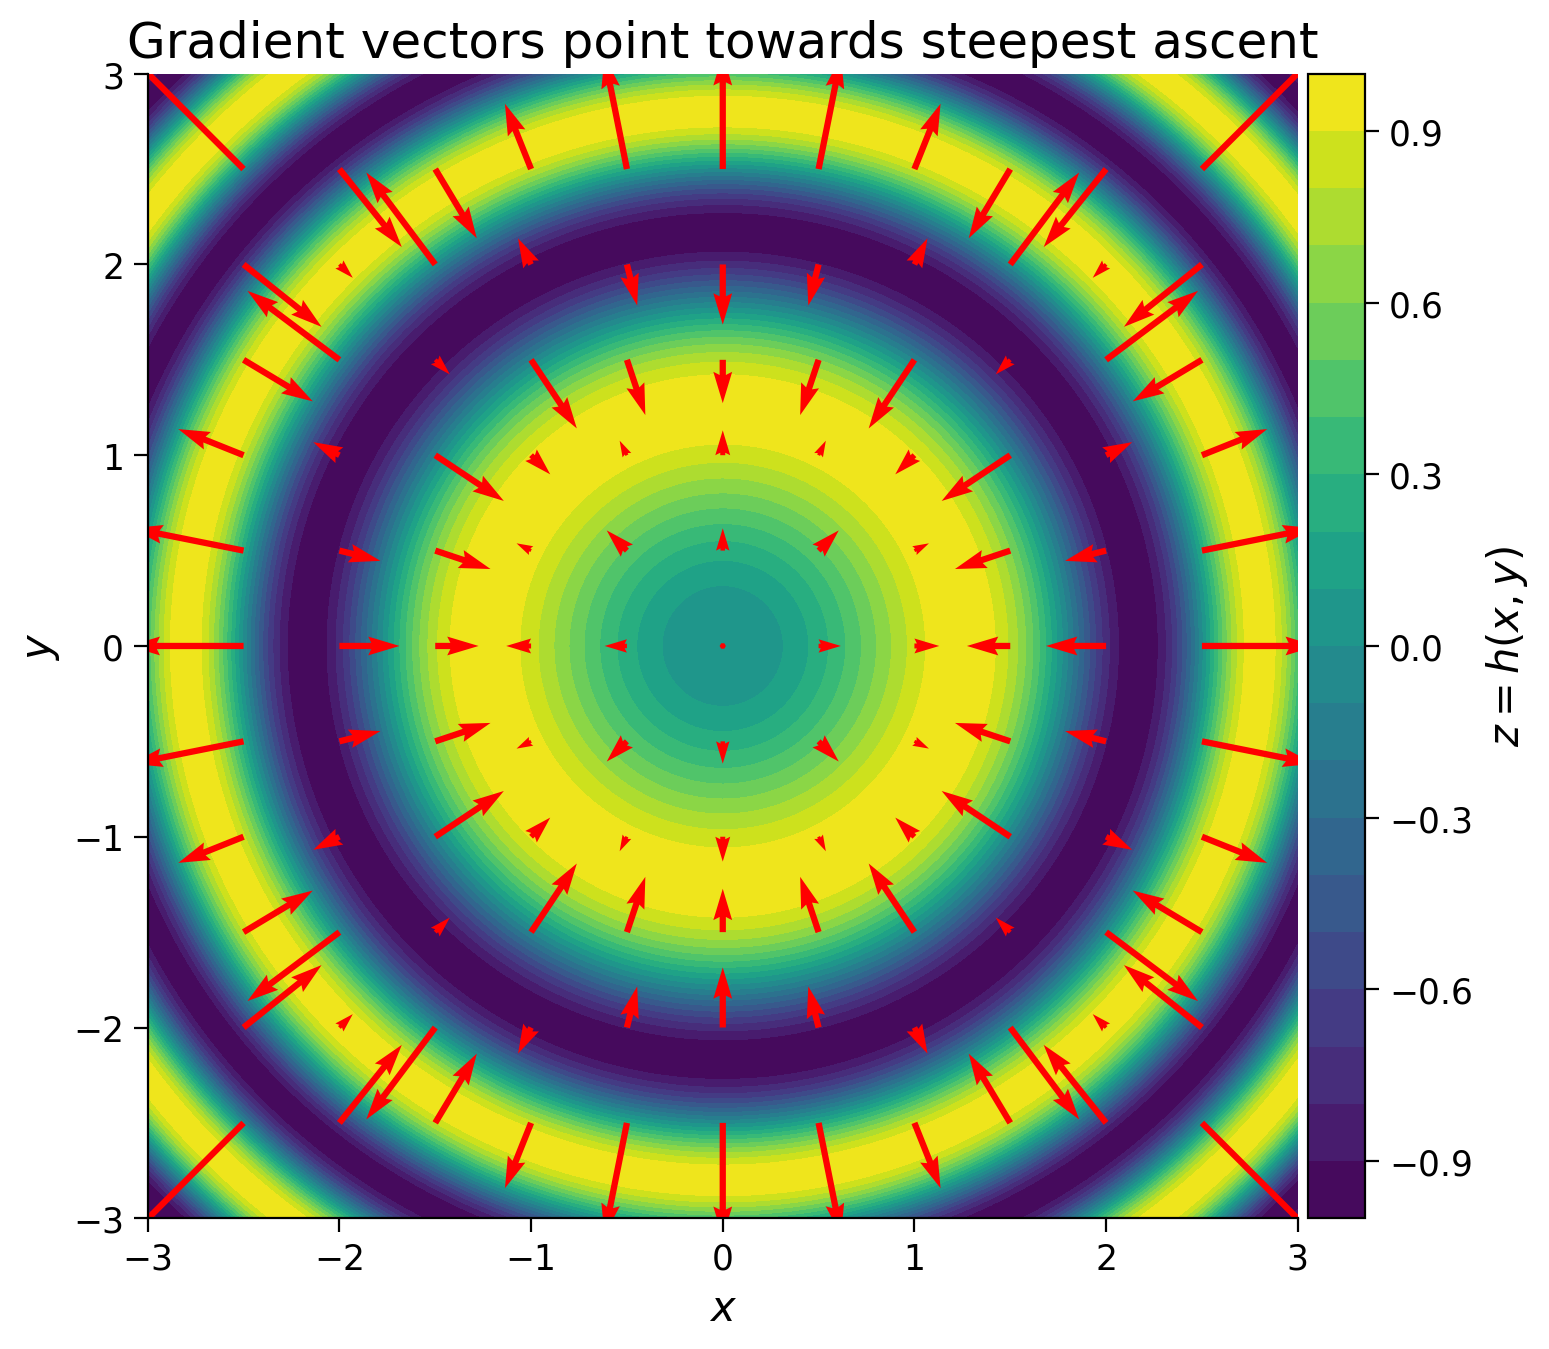

In [ ]:
import numpy as np

def fun_z(x, y):
    """
    Implements function sin(x^2 + y^2)

    Args:
        x: (float, np.ndarray)
          Variable x
        y: (float, np.ndarray)
          Variable y

    Returns:
        z: (float, np.ndarray)
          sin(x^2 + y^2)
    """
    z = np.sin(x**2 + y**2)
    return z

def fun_dz(x, y):
    """
    Computes the gradient vector for sin(x^2 + y^2)

    Args:
        x: (float, np.ndarray)
          Variable x
        y: (float, np.ndarray)
          Variable y

    Returns:
        Tuple of gradient vector for sin(x^2 + y^2)
    """
    dz_dx = 2 * x * np.cos(x**2 + y**2)
    dz_dy = 2 * y * np.cos(x**2 + y**2)

    return (dz_dx, dz_dy)

# Example usage
x_val = 1.0
y_val = 2.0

# Uncomment to run the plot function if provided
ex1_plot(fun_z, fun_dz)
# plot_function_and_gradient()

Solution not provided yet

We can see from the plot that for any given $x_0$ and $y_0$, the gradient vector $\left[ \dfrac{\partial z}{\partial x}, \dfrac{\partial z}{\partial y}\right]^{\top}_{(x_0, y_0)}$ points in the direction of $x$ and $y$ for which $z$ increases the most. It is important to note that gradient vectors only see their local values, not the whole landscape! Also, length (size) of each vector, which indicates the steepness of the function, can be very small near local plateaus (i.e. minima or maxima).

Thus, we can simply use the aforementioned formula to find the local minima.

In 1847, Augustin-Louis Cauchy used **negative of gradients**  to develop the Gradient Descent algorithm as an **iterative** method to **minimize** a **continuous** and (ideally) **differentiable function** of **many variables**.

## Section 1.2: Gradient Descent Algorithm

Let $f(\mathbf{w}): \mathbb{R}^d \rightarrow \mathbb{R}$ be a differentiable function. Gradient Descent is an iterative algorithm for minimizing the function $f$, starting with an initial value for variables $\mathbf{w}$, taking steps of size $\eta$ (learning rate) in the direction of the negative gradient at the current point to update the variables $\mathbf{w}$.

\begin{equation}
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f \left( \mathbf{w}^{(t)} \right)
\end{equation}

where $\eta > 0$ and $\nabla f (\mathbf{w})= \left( \frac{\partial f(\mathbf{w})}{\partial w_1}, ..., \frac{\partial f(\mathbf{w})}{\partial w_d} \right)$. Since negative gradients always point locally in the direction of steepest descent, the algorithm makes small steps at each point **towards** the minimum.

<br/>

**Vanilla Algorithm**

---
> **Inputs:** initial guess $\mathbf{w}^{(0)}$, step size $\eta > 0$, number of steps $T$.

> **For** $t = 0, 1, 2, \dots , T-1$ **do** \
$\qquad$ $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f \left( \mathbf{w}^{(t)} \right)$\
**end**

> **Return:** $\mathbf{w}^{(t+1)}$

---

<br/>

Hence, all we need is to calculate the gradient of the loss function with respect to the learnable parameters (i.e., weights):

\begin{equation}
\dfrac{\partial Loss}{\partial \mathbf{w}} = \left[ \dfrac{\partial Loss}{\partial w_1}, \dfrac{\partial Loss}{\partial w_2} , \dots, \dfrac{\partial Loss}{\partial w_d} \right]^{\top}
\end{equation}

### Analytical Exercise 1.2: Gradients

Given $f(x, y, z) = \tanh \left( \ln \left[1 + z \frac{2x}{sin(y)} \right] \right)$, how easy is it to derive $\dfrac{\partial f}{\partial x}$, $\dfrac{\partial f}{\partial y}$ and $\dfrac{\partial f}{\partial z}$?

**Hint:** You don't have to actually calculate them!

## Section 1.3: Computational Graphs and Backprop


### Computational Graph

*Exercise 1.2* is an example of how overwhelming the derivation of gradients can get, as the number of variables and nested functions increases. This function is still extraordinarily simple compared to the loss functions of modern neural networks. So how can we (as well as PyTorch and similar frameworks) approach such beasts?

Let’s look at the function again:

\begin{equation}
f(x, y, z) = \tanh \left(\ln \left[1 + z \frac{2x}{sin(y)} \right] \right)
\end{equation}

We can build a so-called computational graph (shown below) to break the original function into smaller and more approachable expressions.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/comput_graph.png" alt="Computation Graph" width="700"/></center>

Starting from $x$, $y$, and $z$ and following the arrows and expressions, you would see that our graph returns the same function as $f$. It does so by calculating intermediate variables $a,b,c,d,$ and $e$. This is called the **forward pass**.

Now, let’s start from $f$, and work our way against the arrows while calculating the gradient of each expression as we go. This is called the **backward pass**, from which the **backpropagation of errors** algorithm gets its name.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/comput_graph_full.png" alt="Computation Graph full" width="1200"/></center>

By breaking the computation into simple operations on intermediate variables, we can use the chain rule to calculate any gradient:

\begin{equation}
\dfrac{\partial f}{\partial x} = \dfrac{\partial f}{\partial e}~\dfrac{\partial e}{\partial d}~\dfrac{\partial d}{\partial c}~\dfrac{\partial c}{\partial a}~\dfrac{\partial a}{\partial x} = \left( 1-\tanh^2(e) \right) \cdot \frac{1}{d+1}\cdot z \cdot \frac{1}{b} \cdot 2
\end{equation}

Conveniently, the values for $e$, $b$, and $d$ are available to us from when we did the forward pass through the graph. That is, the partial derivatives have simple expressions in terms of the intermediate variables $a,b,c,d,e$ that we calculated and stored during the forward pass.

### Analytical Exercise 1.3: Chain Rule (Optional)

For the function above, calculate the $\dfrac{\partial f}{\partial y}$ using the computational graph and chain rule.

<details>
<summary> <font color='green'>Click here for the solution </font></summary>

\begin{equation}
\dfrac{\partial f}{\partial y} = \dfrac{\partial f}{\partial e}~\dfrac{\partial e}{\partial d}~\dfrac{\partial d}{\partial c}~\dfrac{\partial c}{\partial b}~\dfrac{\partial b}{\partial y} = \left( 1-\tanh^2(e) \right) \cdot \frac{1}{d+1}\cdot z \cdot \frac{-a}{b^2} \cdot \cos(y)
\end{equation}

For more: [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/)

---
# Section 2: PyTorch AutoGrad

*Time estimate: ~30-45 mins*

### Self Differentiation

Deep learning frameworks such as PyTorch, JAX, and TensorFlow come with a very efficient and sophisticated set of algorithms, commonly known as Automatic Differentiation. AutoGrad is PyTorch's automatic differentiation engine. Here we start by covering the essentials of AutoGrad, and you will learn more in the coming days.

## Section 2.1: Forward Propagation

Everything starts with the forward propagation (pass). PyTorch tracks all the instructions, as we declare the variables and operations, and it builds the graph when we call the `.backward()` pass. PyTorch rebuilds the graph every time we iterate or change it (or simply put, PyTorch uses a dynamic graph).

For gradient descent, it is only required to have the gradients of cost function with respect to the variables we wish to learn. These variables are often called "learnable / trainable parameters" or simply "parameters" in PyTorch. In neural nets, weights and biases are often the learnable parameters.

### Coding Exercise 2.1: Buiding a Computational Graph

In PyTorch, to indicate that a certain tensor contains learnable parameters, we can set the optional argument `requires_grad` to `True`. PyTorch will then track every operation using this tensor while configuring the computational graph. For this exercise, use the provided tensors to build the following graph, which implements a single neuron with scalar input and output.

<br>

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/simple_graph.png" alt="Simple nn graph" width="600"/></center>

In [ ]:
class SimpleGraph:
  """
  Implementing Simple Computational Graph
  """

  def __init__(self, w, b):
    """
    Initializing the SimpleGraph

    Args:
      w: float
        Initial value for weight
      b: float
        Initial value for bias

    Returns:
      Nothing
    """
    assert isinstance(w, float)
    assert isinstance(b, float)
    self.w = torch.tensor([w], requires_grad=True)
    self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        1D tensor of features

      y: torch.Tensor
        1D tensor of targets

    Returns:
      prediction: torch.Tensor
        Model predictions
    """
    assert isinstance(x, torch.Tensor)
    #################################################
    ## Implement the the forward pass to calculate prediction
    ## Note that prediction is not the loss, but the value after `tanh`
    # Complete the function and remove or comment the line below
    # raise NotImplementedError("Forward Pass `forward`")
    #################################################
    prediction = torch.tanh(self.w * x + self.b)
    return prediction


def sq_loss(y_true, y_prediction):
  """
  L2 loss function

  Args:
    y_true: torch.Tensor
      1D tensor of target labels
    y_prediction: torch.Tensor
      1D tensor of predictions

  Returns:
    loss: torch.Tensor
      L2-loss (squared error)
  """
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)
  #################################################
  ## Implement the L2-loss (squred error) given true label and prediction
  # Complete the function and remove or comment the line below
  # raise NotImplementedError("Loss function `sq_loss`")
  #################################################
  loss = torch.mean((y_true - y_prediction)**2)
  return loss



feature = torch.tensor([1])  # Input tensor
target = torch.tensor([7])  # Target tensor
## Uncomment to run
simple_graph = SimpleGraph(-0.5, 0.5)
print(f"initial weight = {simple_graph.w.item()}, "
      f"\ninitial bias = {simple_graph.b.item()}")
prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)
print(f"for x={feature.item()} and y={target.item()}, "
      f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")

initial weight = -0.5, 
initial bias = 0.5
for x=1 and y=7, prediction=0.0, and L2 Loss = 49.0


Solution not provided yet

It is important to appreciate the fact that PyTorch can follow our operations as we arbitrarily go through classes and functions.

## Section 2.2: Backward Propagation

Here is where all the magic lies. In PyTorch, `Tensor` and `Function` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each variable has a `grad_fn` attribute that references a function that has created the Tensor (except for Tensors created by the user - these have `None` as `grad_fn`).  The example below shows that the tensor `c = a + b` is created by the `Add` operation and the gradient function is the object `<AddBackward...>`. Replace `+` with other single operations (e.g., `c = a * b` or `c = torch.sin(a)`) and examine the results.

In [ ]:
a = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([-1.0], requires_grad=True)
c = a + b
print(f'Gradient function = {c.grad_fn}')

Gradient function = <AddBackward0 object at 0x7f3cf80d7850>


For more complex functions, printing the `grad_fn` would only show the last operation, even though the object tracks all the operations up to that point:

In [ ]:
print(f'Gradient function for prediction = {prediction.grad_fn}')
print(f'Gradient function for loss = {square_loss.grad_fn}')

Gradient function for prediction = <TanhBackward0 object at 0x7f3cf6cdd630>
Gradient function for loss = <MeanBackward0 object at 0x7f3cdc267cd0>


Now let's kick off the backward pass to calculate the gradients by calling `.backward()` on the tensor we wish to initiate the backpropagation from. Often, `.backward()` is called on the loss, which is the last node on the graph. Before doing that, let's calculate the loss gradients by hand:

$$\frac{\partial{loss}}{\partial{w}} = - 2 x (y_t - y_p)(1 - y_p^2)$$

$$\frac{\partial{loss}}{\partial{b}} = - 2 (y_t - y_p)(1 - y_p^2)$$

Where $y_t$ is the target (true label), and $y_p$ is the prediction (model output). We can then compare it to PyTorch gradients, which can be obtained by calling `.grad` on the relevant tensors.

**Important Notes:**
* Learnable parameters (i.e. `requires_grad` tensors) are "contagious". Let's look at a simple example: `Y = W @ X`, where `X` is the feature tensors and `W` is the weight tensor (learnable parameters, `requires_grad`), the newly generated output tensor `Y` will be also `requires_grad`. So any operation that is applied to `Y` will be part of the computational graph. Therefore, if we need to plot or store a tensor that is `requires_grad`, we must first `.detach()` it from the graph by calling the `.detach()` method on that tensor.

* `.backward()` accumulates gradients in the leaf nodes (i.e., the input nodes to the node of interest). We can call `.zero_grad()` on the loss or optimizer to zero out all `.grad` attributes (see [autograd.backward](https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward) for more information).

* Recall that in python we can access variables and associated methods with `.method_name`. You can use the command `dir(my_object)` to observe all variables and associated methods to your object, e.g., `dir(simple_graph.w)`.

In [ ]:
# Analytical gradients (Remember detaching)
ana_dloss_dw = - 2 * feature * (target - prediction.detach())*(1 - prediction.detach()**2)
ana_dloss_db = - 2 * (target - prediction.detach())*(1 - prediction.detach()**2)

square_loss.backward()  # First we should call the backward to build the graph
autograd_dloss_dw = simple_graph.w.grad  # We calculate the derivative w.r.t weights
autograd_dloss_db = simple_graph.b.grad  # We calculate the derivative w.r.t bias

print(ana_dloss_dw == autograd_dloss_dw)
print(ana_dloss_db == autograd_dloss_db)

tensor([True])
tensor([True])


### References and more

* [A gentle introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

* [Automatic Differentiation package - torch.autograd](https://pytorch.org/docs/stable/autograd.html)

* [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html)

* [Automatic Differentiation with torch.autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

---
# Section 3: PyTorch's Neural Net module (`nn.Module`)

*Time estimate: ~30 mins*

### PyTorch `nn` module

PyTorch provides us with ready-to-use neural network building blocks, such as layers (e.g., linear, recurrent, etc.), different activation and loss functions, and much more, packed in the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module. If we build a neural network using `torch.nn` layers, the weights and biases are already in `requires_grad` mode and will be registered as model parameters.

For training, we need three things:

* **Model parameters:** Model parameters refer to all the learnable parameters of the model, which are accessible by calling `.parameters()` on the model. Please note that NOT all the `requires_grad` tensors are seen as model parameters. To create a custom model parameter, we can use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (*A kind of Tensor that is to be considered a module parameter*).

* **Loss function:** The loss that we are going to be optimizing, which is often combined with regularization terms (coming up in few days).

* **Optimizer:** PyTorch provides us with many optimization methods (different versions of gradient descent). Optimizer holds the current state of the model and by calling the `step()` method, will update the parameters based on the computed gradients.

You will learn more details about choosing the right model architecture, loss function, and optimizer later in the course.

## Section 3.1: Training loop in PyTorch

We use a regression problem to study the training loop in PyTorch.

The task is to train a wide nonlinear (using $\tanh$ activation function) neural net for a simple $\sin$ regression task. Wide neural networks are thought to be really good at generalization.

Random seed 2021 has been set.


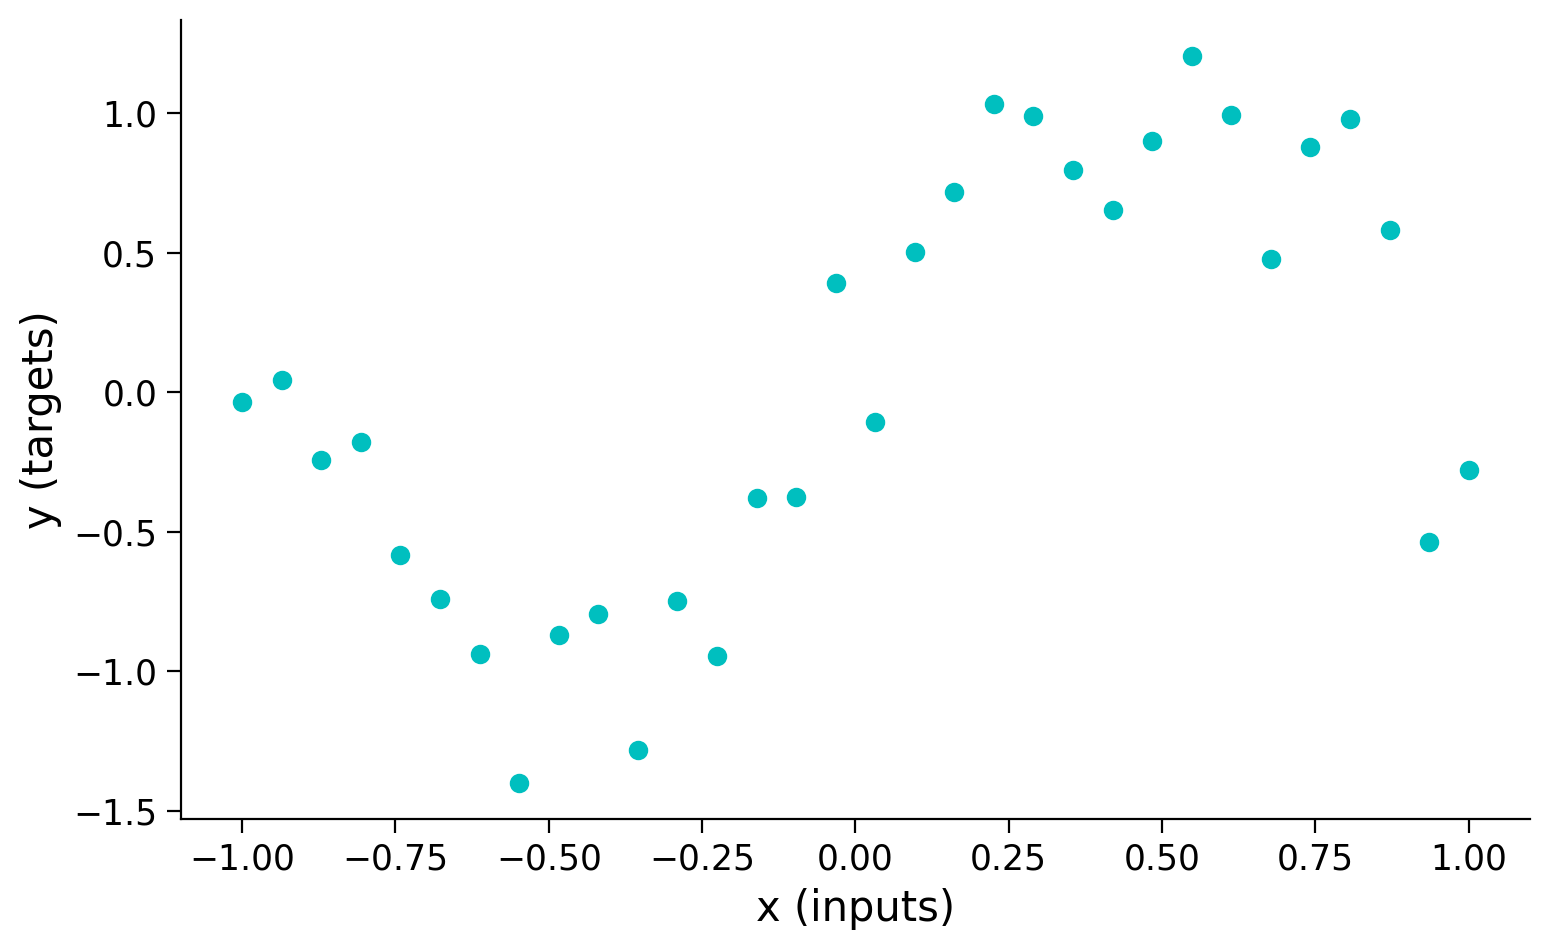

In [ ]:
# @markdown #### Generate the sample dataset
set_seed(seed=SEED)
n_samples = 32
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 4
targets = torch.sin(pi * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

Let's define a very wide (512 neurons) neural net with one hidden layer and `nn.Tanh()` activation function.

In [ ]:
class WideNet(nn.Module):
  """
   A Wide neural network with a single hidden layer
   Structure is as follows:
   nn.Sequential(
        nn.Linear(1, n_cells) + nn.Tanh(), # Fully connected layer with tanh activation
        nn.Linear(n_cells, 1) # Final fully connected layer
    )
  """

  def __init__(self):
    """
    Initializing the parameters of WideNet

    Args:
      None

    Returns:
      Nothing
    """
    n_cells = 512
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, n_cells),
        nn.Tanh(),
        nn.Linear(n_cells, 1),
    )

  def forward(self, x):
    """
    Forward pass of WideNet

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """
    return self.layers(x)

We can now create an instance of our neural net and print its parameters.

In [ ]:
# Creating an instance
set_seed(seed=SEED)
wide_net = WideNet()
print(wide_net)

Random seed 2021 has been set.
WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [ ]:
# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer (you will learn about momentum soon)
lr = 0.003  # Learning rate
sgd_optimizer = torch.optim.SGD(wide_net.parameters(), lr=lr, momentum=0.9)

The training process in PyTorch is interactive - you can perform training iterations as you wish and inspect the results after each iteration.

Let's perform one training iteration. You can run the cell multiple times and see how the parameters are being updated and the loss is reducing. This code block is the core of everything to come: please make sure you go line-by-line through all the commands and discuss their purpose with your pod.

In [ ]:
# Reset all gradients to zero
sgd_optimizer.zero_grad()

# Forward pass (Compute the output of the model on the features (inputs))
prediction = wide_net(inputs)

# Compute the loss
loss = loss_function(prediction, targets)
print(f'Loss: {loss.item()}')

# Perform backpropagation to build the graph and compute the gradients
loss.backward()

# Optimizer takes a tiny step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

Loss: 0.8889423608779907


### Coding Exercise 3.1: Training Loop

Using everything we've learned so far, we ask you to complete the `train` function below.

Random seed 2021 has been set.


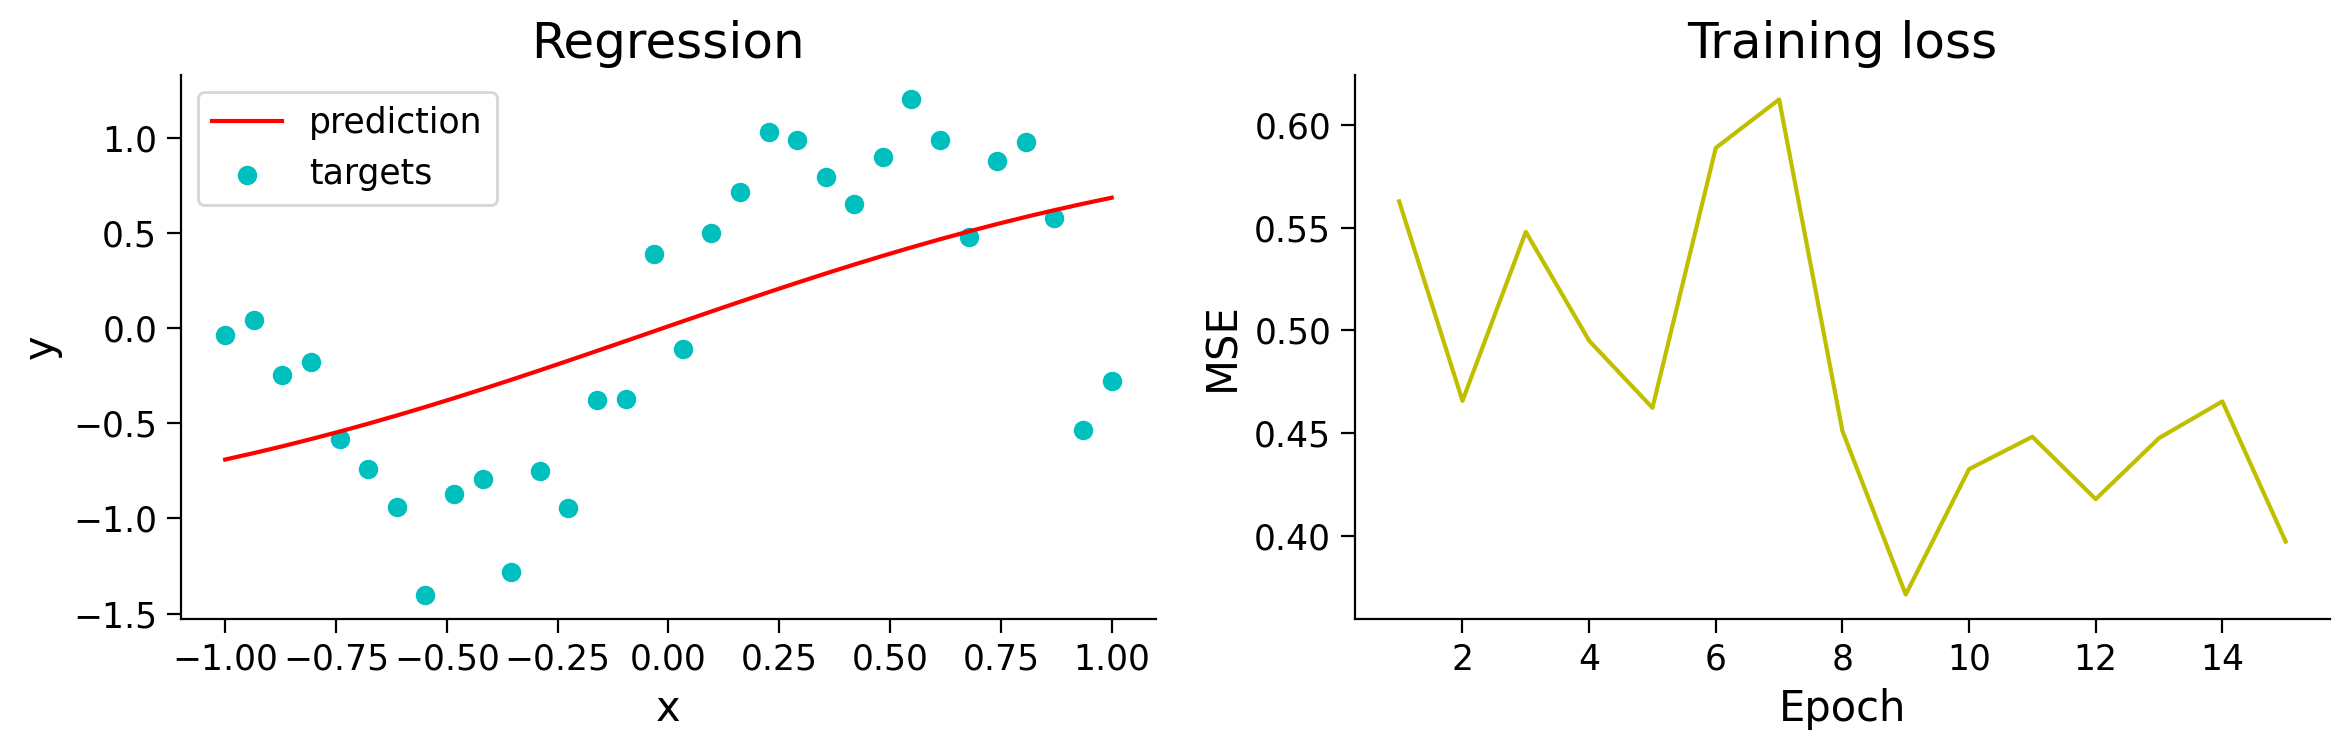

In [ ]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):
    """
    Training function

    Args:
        features: torch.Tensor
          Features (input) with shape torch.Size([n_samples, 1])
        labels: torch.Tensor
          Labels (targets) with shape torch.Size([n_samples, 1])
        model: torch nn.Module
          The neural network
        loss_fun: function
          Loss function
        optimizer: function
          Optimizer
        n_epochs: int
          Number of training iterations

    Returns:
        loss_record: list
          Record (evolution) of training losses
    """
    loss_record = []  # Keeping records of loss

    for i in range(n_epochs):
        optimizer.zero_grad()  # Set gradients to 0
        predictions = model(features)  # Compute model prediction (output)
        loss = loss_fun(predictions, labels)  # Compute the loss
        loss.backward()  # Compute gradients (backward pass)
        optimizer.step()  # Update parameters (optimizer takes a step)

        loss_record.append(loss.item())  # Append the current loss to the loss record

    return loss_record

# Example usage
set_seed(seed=2021)
epochs = 15  # Cauchy, Exercices d'analyse et de physique mathematique (1847)
# Uncomment to run
losses = train(inputs, targets, wide_net, loss_function, sgd_optimizer, epochs)
ex3_plot(wide_net, inputs, targets, epochs, losses)


Solution not provided yet

---
# Summary

In this tutorial, we covered one of the most basic concepts of deep learning; the computational graph and how a network learns via gradient descent and the backpropagation algorithm. We have seen all of these using PyTorch modules and we compared the analytical solutions with the ones provided directly by the PyTorch module.